In [3]:
%pip install argovisHelpers==0.0.15 scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 556.5 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
Note: you may need to restart the kernel to use updated packages.


# Introduction to atmospheric rivers in Argovis

Argovis indexes several decades of atmospheric rivers (ARs) as described in https://doi.org/10.1175/MWR-D-13-00168.1. These are an example of Argovis' _extended objects_ schema; whereas most datasets Argovis index are point data localized to individual latitude and longitude, extended objects are potentially large regions on the globe. In this notebook, we'll explore the extended objects schema, and make some simple plots.

## Basic downloads and schema

As usual, let's start by importing some packages and pasting in your API key:

In [11]:
from argovisHelpers import helpers as avh
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

Extended objects in Argovis have the same query string filters you're familiar with from our point-like data. Let's download ARs off the cost of California in December of 2000, and then look at what keys are available in the extended objects schema:

In [20]:
ar_params = {
    'startDate': '2000-12-01T00:00:00Z',
    'endDate': '2001-01-01T00:00:00Z',
    'polygon': [[-123.96875621015012,42.3490121003492],[-127.20778541454463,42.35744120137031],[-122.5305240983426,33.5619009930447],[-117.98370022224773,32.00306129531103],[-116.3988770666693,32.88138480315358],[-123.96875621015012,42.3490121003492]]
}

ar = avh.query('extended/ar', options=ar_params, apikey=API_KEY, apiroot=API_ROOT)
print(ar[0].keys())

dict_keys(['_id', 'timestamp', 'basins', 'raster', 'flags', 'geolocation', 'metadata'])


`_id`, `timestamp` and `metadata` are identical to the point schema; `basins` is also similar, but is now a list for extended objects as they may intersect multiple ocean basins.

Geolocation in extended objects is a geojson MultiPolygon, rather than a Point; it describes the boundary of the phenomenon.

In [21]:
print(ar[0]['geolocation'])

{'type': 'MultiPolygon', 'coordinates': [[[[-156.5625, 27.75], [-155.9375, 27.75], [-155.3125, 27.75], [-154.6875, 27.75], [-154.0625, 27.75], [-153.4375, 27.75], [-152.8125, 27.75], [-152.8125, 28.25], [-152.1875, 28.25], [-151.5625, 28.25], [-151.5625, 28.75], [-150.9375, 28.75], [-150.3125, 28.75], [-150.3125, 29.25], [-149.6875, 29.25], [-149.6875, 29.75], [-149.0625, 29.75], [-148.4375, 29.75], [-148.4375, 30.25], [-147.8125, 30.25], [-147.1875, 30.25], [-147.1875, 29.75], [-147.8125, 29.75], [-147.8125, 29.25], [-147.8125, 28.75], [-147.8125, 28.25], [-147.8125, 27.75], [-147.1875, 27.75], [-147.1875, 28.25], [-146.5625, 28.25], [-146.5625, 28.75], [-145.9375, 28.75], [-145.3125, 28.75], [-145.3125, 29.25], [-144.6875, 29.25], [-144.6875, 29.75], [-144.0625, 29.75], [-144.0625, 30.25], [-143.4375, 30.25], [-143.4375, 30.75], [-143.4375, 31.25], [-142.8125, 31.25], [-142.8125, 31.75], [-142.1875, 31.75], [-142.1875, 32.25], [-142.1875, 32.75], [-141.5625, 32.75], [-141.5625, 33.25

Another novel property of extended objects is the `raster` property. This captures any available data from longitude / latitude points in the interior or boundary of the phenonmenon:

In [22]:
print(ar[0]['raster'][0:10])

[[-156.875, 28, [269.6921691894531]], [-156.25, 28, [282.5484619140625]], [-155.625, 28, [286.5152893066406]], [-155, 28, [278.540283203125]], [-154.375, 28, [270.6352233886719]], [-153.75, 28, [266.0003356933594]], [-153.125, 28, [256.5028076171875]], [-147.5, 28, [251.04200744628906]], [-156.875, 28.5, [259.0686340332031]], [-156.25, 28.5, [288.2287902832031]]]


The format of the elements in the `raster` list is `[longitude, latitude, (tuple of measurements)]`. In order to interpret the measurements, we use the `data_info` key from the metadata, similar to point data:

In [23]:
ar_meta_params = {
    'id': ar[0]['metadata'][0]
}

ar_meta = avh.query('extended/meta', options=ar_meta_params, apikey=API_KEY, apiroot=API_ROOT, verbose=True)
print(ar_meta[0]['data_info'])

https://argovis-api.colorado.edu/extended/meta?id=ar
[['ivt'], ['units', 'long_name'], [['kg/m/s', 'integrated water vapor transport']]]


The only measurment in the AR raster is apparently integrated water vapor transport, measured in kg/m/s.
Let's write a function to plot both the boundary and the raster of an extended object, and use it to plot some of the ARs we downloaded:

In [37]:
def genplot(AR, fig, subrows=1, subcols=1, fign=1):
    ax = fig.add_subplot(subrows, subcols, fign, projection=ccrs.LambertConformal(cutoff=-60))
    gl = ax.gridlines(draw_labels=True,color='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    for blob in AR['geolocation']['coordinates']:
        for loop in blob:
            plt.plot([x[0] for x in loop],[x[1] for x in loop],'-k', linewidth=3, color='red',transform=ccrs.PlateCarree())
    for r in AR['raster']:
        plt.plot(r[0], r[1], 'bo', markersize=1, transform=ccrs.PlateCarree(central_longitude=0)) 
    if 'timestamp' in AR:
        plt.title(AR['timestamp'])

We can see a large AR evolving in the early hours of December 20:

/tmp/ipykernel_10/2871331414.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x[0] for x in loop],[x[1] for x in loop],'-k', linewidth=1, color='red',transform=ccrs.PlateCarree())


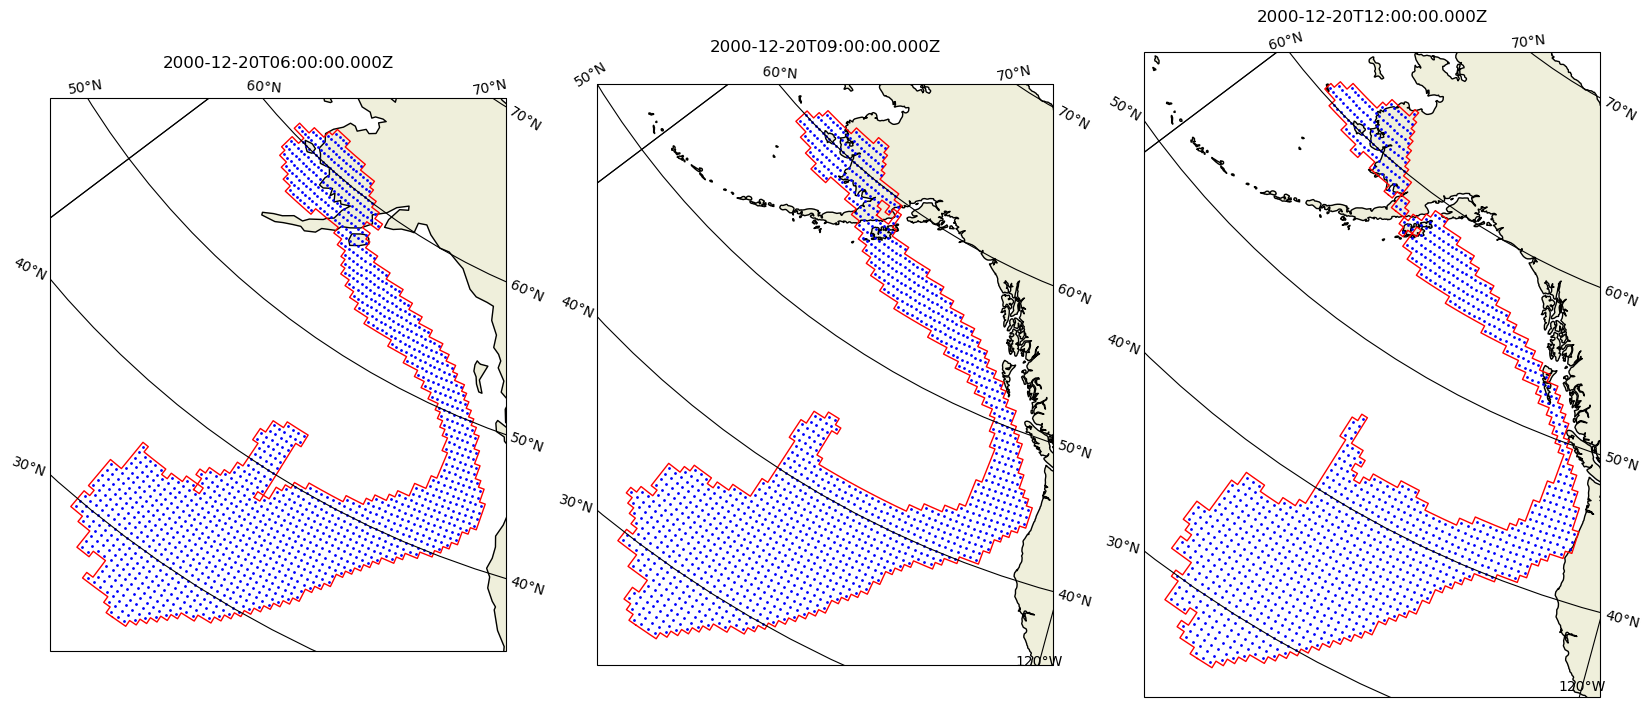

In [73]:
fig = plt.figure(figsize=(20,10))
genplot(ar[20], fig, subrows=1,subcols=3,fign=1)
genplot(ar[19], fig, subrows=1,subcols=3,fign=2)
genplot(ar[18], fig, subrows=1,subcols=3,fign=3)

In the afternoon of that day, the two sections of this AR split apart. Argovis interprets any contiguous region of AR activity in the source grid of AR data as a single AR; once the thinner northern filament of this AR became no longer contiguous with the souther mass, they begin to be recorded as separate ARs. Below we continue observing the evolution of the southern section:

/tmp/ipykernel_10/2871331414.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x[0] for x in loop],[x[1] for x in loop],'-k', linewidth=1, color='red',transform=ccrs.PlateCarree())


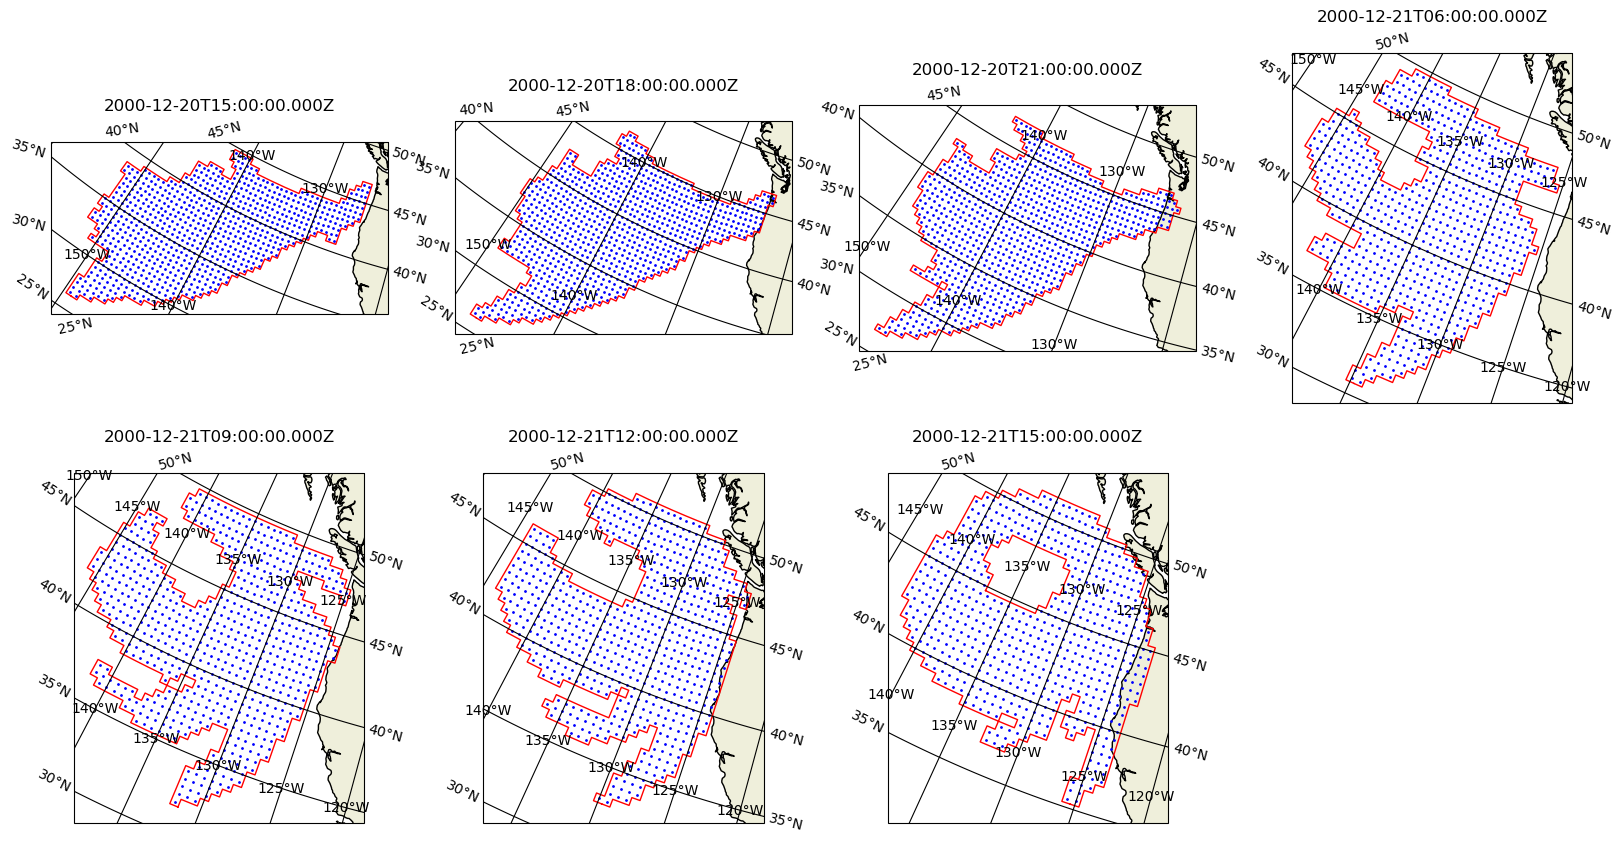

In [75]:
fig = plt.figure(figsize=(20,10))
genplot(ar[17], fig, subrows=2,subcols=4,fign=1)
genplot(ar[16], fig, subrows=2,subcols=4,fign=2)
genplot(ar[15], fig, subrows=2,subcols=4,fign=3)
genplot(ar[14], fig, subrows=2,subcols=4,fign=4)
genplot(ar[13], fig, subrows=2,subcols=4,fign=5)
genplot(ar[12], fig, subrows=2,subcols=4,fign=6)
genplot(ar[11], fig, subrows=2,subcols=4,fign=7)

In the same fashion, more AR activity may coalesce as time goes on:

/tmp/ipykernel_10/2871331414.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x[0] for x in loop],[x[1] for x in loop],'-k', linewidth=1, color='red',transform=ccrs.PlateCarree())


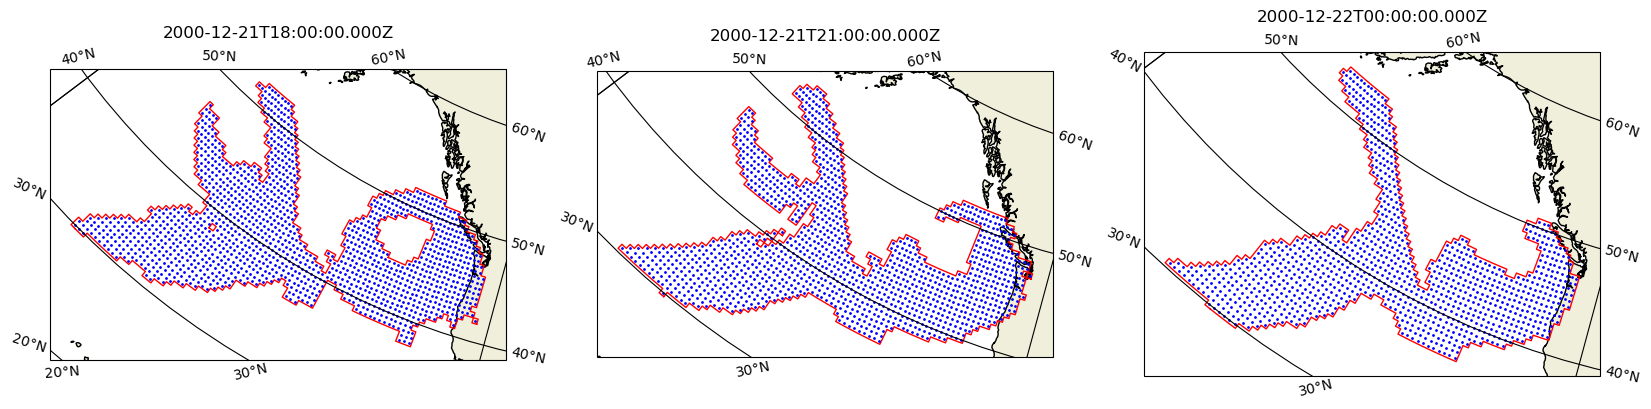

In [76]:
fig = plt.figure(figsize=(20,10))
genplot(ar[10], fig, subrows=1,subcols=3,fign=1)
genplot(ar[9], fig, subrows=1,subcols=3,fign=2)
genplot(ar[8], fig, subrows=1,subcols=3,fign=3)


## Flags and helpers

The observant reader will have noticed a `flags` key in the extended objects schema; these are meant to flag interesting and potentially pathological or opinionated cases in our boundary tracing helpers used to draw the perimeters around binary grids indicating the presence of ARs. Possible values of flags for ARs are:

 - `annulus`: this shape wraps around the entire globe.
 - `dateline`: this shape crosses the dateline.
 - `holes`: this shape has interior holes.
 - `north_pole` and `south_pole`: this shape covers the respective pole.
 - `noise_added`: in rare cases, a multipolygon will fail to index in mongodb due to the database bug https://jira.mongodb.org/browse/SERVER-52928. In this case, the shape is randomly shifted by less than a billionth of a degree.
 - `region_subdivided`: in cases of very large ARs, typically annular ARs wrapping the planet near the equator, it can be difficult to correctly define the interior of such a region in MongoDB. In these cases, we artifically divide the geojson multipolygon into sub-hemispherical regions in a way that won't affect polygon search intersections.
 
In the case of ARs flagged with either `noise_added` or `region_subdivided`, the unmanipulated geolocation will be made available on the optional data key `true_geolocation`.

For interested parties, the algorithm used to generate the MultiPolygons that define the boundaries of AR objects based on binary raster grids (ie grids that indicate the presence of an AR with a 1 and absense with a 0) have been made available in our helpers package. We begin with a binary feature map where rows represent latitude bins, and columns represent longitude bins; we then use the label features helper to identify distinct 'blobs' and give them an index:

In [32]:
from argovisHelpers import gridtools as gt

binary_features = [
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,1,0,1,0,0,0,0],
    [0,1,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0],
    [1,1,0,0,0,0,0,1],
    [0,0,0,0,0,0,0,0]
]
labeled_map = gt.label_features(binary_features)
print(labeled_map)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0]
 [2 2 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0]]


Note by default, we assume blobs are allowed to wrap around the dateline, like object index 2 above.

Next we can use another helper to turn one of these blobs into a geojson object. To do this, we have to provide a mapping function to translate longitude and latitude columns and rows into actual coordinates.

In [35]:
def index2coords(index):
    # a function to take an index from the feature map and turn it into a longitude, latitude pair
    # for this trivial example, we'll just use the index values as coordinates.
    return [index[0]*10, index[1]*10]

geo = gt.generate_geojson(
    labeled_map, 
    1, 
    index2coords
)
print(geo)

({'type': 'MultiPolygon', 'coordinates': [[[[20, 20], [20, 10], [30, 10], [40, 10], [50, 10], [50, 20], [50, 30], [50, 40], [40, 40], [30, 40], [20, 40], [20, 30], [20, 20]], [[30, 20], [30, 30], [40, 30], [40, 20], [30, 20]]]]}, {'holes'})


Finally, let's plot what we got on a map:

/tmp/ipykernel_58/4253409332.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([x[0] for x in loop],[x[1] for x in loop],'-k', linewidth=3, color='red',transform=ccrs.PlateCarree())


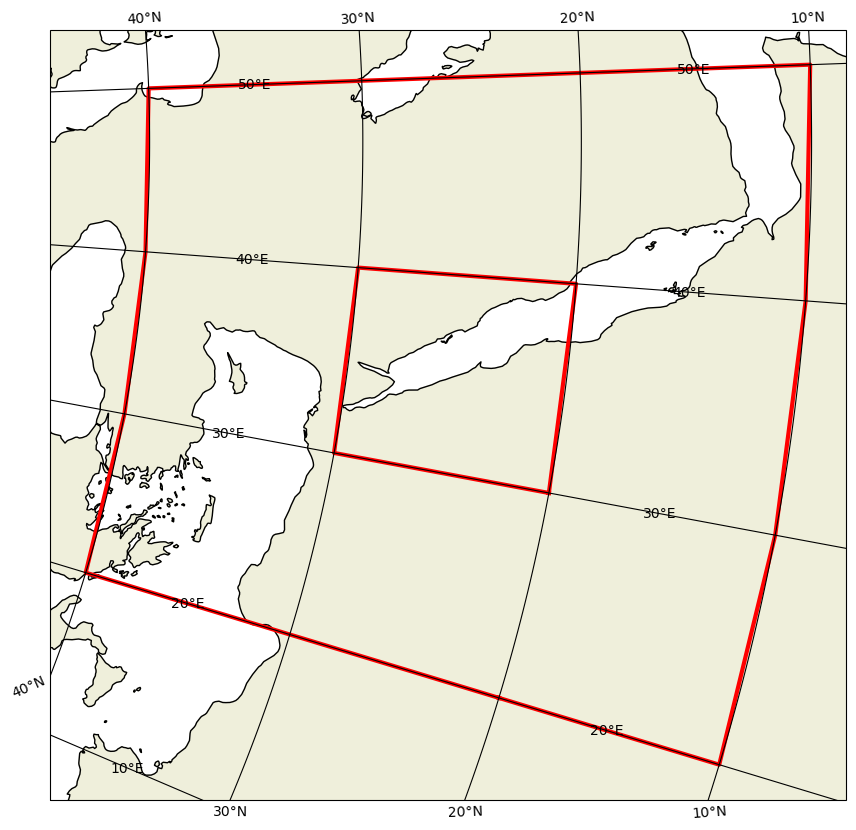

In [38]:
fig = plt.figure(figsize=(20,10))
genplot({'geolocation':geo[0], 'raster':[]}, fig)